In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import minimize
import os
import re

In [2]:
'''
#Using the "actual" data from nrel

# Load and pre-process data from https://www.nrel.gov/grid/solar-power-data
df = pd.read_csv("Actual_36.25_-102.95_2006_UPV_84MW_5_Min.csv")
df['LocalTime'] = pd.to_datetime(df['LocalTime'], format="%m/%d/%y %H:%M")
df['DateOnly'] = df['LocalTime'].dt.date
df['TimeOnly'] = df['LocalTime'].apply(lambda dt: dt.replace(year=2006,month=1, day=1))
df['Power(MW)'] /= 84 # Normalize to 1 MW array
'''

# Converts any sized solar time-series to 1 MW normalized version
def load_solar_timeseries(path, plant_capacity_MW=None):
    """
    Load a LocalTime, Power(MW) file and normalize to 1 MW.
    If plant_capacity_MW is None, tries to infer it from the filename (e.g. '_84MW_').
    """

    df = pd.read_csv(path)

    # Parse LocalTime
    df['LocalTime'] = pd.to_datetime(df['LocalTime'], format="%m/%d/%y %H:%M")
    df['DateOnly']  = df['LocalTime'].dt.date
    df['TimeOnly']  = df['LocalTime'].apply(lambda dt: dt.replace(year=2006, month=1, day=1))

    # Infer capacity from filename if not given
    if plant_capacity_MW is None:
        m = re.search(r'_(\d+)MW_', path)
        if m:
            plant_capacity_MW = float(m.group(1))
        else:
            plant_capacity_MW = 1.0  # default for your generated 1 MW files

    # Normalize to 1 MW
    df['Power(MW)'] = df['Power(MW)'] / plant_capacity_MW

    return df

# Infer timestep from time-series DataFrame
def infer_timestep(df: pd.DataFrame, time_col: str = "LocalTime"):
    """
    Infer the timestep from a time-series DataFrame.
    
    Returns
    -------
    dt_minutes : float
        Most common timestep in minutes.
    dt_hours   : float
        Most common timestep in hours.
    """
    # Ensure datetime
    ts = pd.to_datetime(df[time_col]).dropna().sort_values()

    if len(ts) < 2:
        raise ValueError("Not enough rows to infer timestep")

    # Differences between consecutive timestamps
    deltas = ts.diff().dropna()

    # Convert to minutes
    dt_minutes = (deltas.dt.total_seconds() / 60.0).mode().iloc[0]
    dt_hours   = dt_minutes / 60.0

    return dt_minutes, dt_hours




In [3]:

# will need to add a generator output
# need gen cost, fuel cost, efficiency conversion between them
# first round implementation has generator just turning on when solar and battery can't meet load, lookahead function can be implemented later that allows weather prediction


def uptime_with_generator(
    capacity: float, 
    gen_capacity: float, #yes I know capacity and capacity are two different units
    load: float, 
    sol: list[float]
) -> tuple[float,float]:
    """
    Return:
      utilization: average fraction of load served (0–1)
      gen_energy: total generator electrical energy produced over the year [MWh],
                  in the *normalized* model.
    """

    battery_charge: float = capacity # MWh
    cum_utilization: float = 0.0
    gen_energy: float = 0.0 #new term to track cumulative energy from generator
    delta_t = dt_hours 
    gen_output: float = 0.0

    for s_i in sol:
        # First see what solar + battery can do (your existing logic)
        can_do_without_gen = min(load, s_i + battery_charge / delta_t)

        # If that’s not enough, ask the generator to cover the shortfall, up to its capacity
        if can_do_without_gen < load and gen_capacity > 0.0:
            needed = load - can_do_without_gen
            gen_output = min(needed, gen_capacity)    # MW
        else:
            gen_output = 0.0



        supplied = can_do_without_gen + gen_output

        # Track utilization and generator energy
        cum_utilization += supplied / load
        gen_energy += gen_output * delta_t  # MWh

        # Battery update – leave as in your current code (only solar vs. load)
        delta_energy = (s_i + gen_output - load) * delta_t
        battery_charge = max(0.0, min(capacity, battery_charge + delta_energy))

    utilization = cum_utilization / len(sol)
    return utilization, gen_energy

def all_in_system_cost(
    solar_cost: float, # $/MW
    battery_cost: float, # $/MWh
    load_cost: float, # $/MW
    gen_capex: float,       # $/MW (generator capex)
    gen_fuel: float,        # $/MWh (generator fuel+VOM)
    battery_size: float, # MWh
    array_size: float, # MW
    gen_size: float,        # MW generator per 1 MW of load
    # load size is implicitly 1 MW
    sol: list[float], # n-minutely solar farm production for a normalized 1 MW farm
    ) -> float:
    """ Return all-in capex+fuel cost per MWh delivered by the system ($/MWh)."""

    # Normalization to "1 MW solar" world, same trick as your current code
    cap_norm   = battery_size / array_size        # MWh per 1 MW PV
    load_norm  = 1.0 / array_size                 # MW load per 1 MW PV
    gen_norm   = gen_size / array_size            # MW gen per 1 MW PV

    utilization, gen_energy_norm = uptime_with_generator(
        cap_norm, gen_norm, load_norm, sol
    )

    if utilization <= 0:
    # System never serves load → effectively infinite $/MWh
        return 1e20

    # Scale generator energy back to "per MW of load"
    # In the real system, solar & load are array_size× larger than the normalized model
    gen_energy_per_MW_load = gen_energy_norm * array_size  # MWh per MW of load per year

    # Capex per MW of load
    capex = (
        battery_size * battery_cost +
        array_size  * solar_cost +
        gen_size    * gen_capex +
        1.0         * load_cost  # 1 MW of load
    )

    # All to serve 1MW of LOAD. (The utilization function uses input data for 1MW solar)

   # Fuel cost per MW of load over the modeled year
    fuel_cost = gen_energy_per_MW_load * gen_fuel

    fixed_cost = capex # $/MW of load
    variable_cost = fuel_cost # $/MW of load (per year)

    # annualize capex


    # Example: 7% discount rate over 20 years
    # Or simply divide Capex by lifespan if simplified
    # CRF = (r(1+r)^n) / ((1+r)^n - 1)
    # Let's assume a roughly 10% annualization factor for simplicity or use your plotting logic
    annualization_factor = 0.10 

    annualized_capex = capex * annualization_factor
    
    # Now they are both in $/year
    total_annual_cost = annualized_capex + fuel_cost 
    
    # Return cost per MWh served
    total_annual_load_served = 8760 * utilization # (since load is 1MW) # also this hard codes a one year time series
    return total_annual_cost / total_annual_load_served

    # exanded return values for breakdown

    '''
    return {
        "total": total_annual_cost / total_annual_load_served,
        "solar_capex": (array_size * solar_cost * annualization_factor) / (8760*utilization),
        "battery_capex": (battery_size * battery_cost * annualization_factor) / (8760*utilization),
        "gen_capex": (gen_size * gen_capex * annualization_factor) / (8760*utilization),
        "fuel": fuel_cost / total_annual_load_served,
    }
    '''




In [4]:
# Run one optimization per load cost scenario
battery_cost = 200e3 # $/MWh. Real world number here seem to be about 200k to 300k
solar_cost = 600e3 # $/MW. Real world numbers range from 600k to 1.2M. See IRENA
gen_capex = 800e3  # $/MW   This number varies widely based on generator type
fuel_cost = 40 #$/MWh, realistic number for US natural gas (about $15 in the US, about $35 in europe and LNG, add $5 for variable O&M of generator)
generator_efficiency = 0.35 #35% efficiency typical for natural gas generator
gen_fuel = fuel_cost / generator_efficiency  # $/MWh_e (fuel + variable O&M)

#input any size MW solar array file here
solar_array_file = "1MW Arrays\\Generated_50.73_9.70_2019_1MW_30_Min - Copy.csv"
df = load_solar_timeseries(solar_array_file)
dt_minutes, dt_hours = infer_timestep(df, time_col="LocalTime")
print(f"Inferred timestep: {dt_minutes} minutes ({dt_hours} hours)")


load_costs = np.logspace(4, 10, num=20)
battery_sizes = []
array_sizes = []
gen_sizes = []
fuel_costs = [] #adding fuel cost
uptimes = []
my_sol = df['Power(MW)'].to_numpy()

#adding warm starting
x0 = np.array([0, 1.0, 0.0])  # battery (MWh), array (MW), gen (MW)
prev_x = x0

for load_cost in load_costs:
    def cost_function(args):
        battery_size, array_size, gen_size = args
        return all_in_system_cost(
            solar_cost, battery_cost, load_cost,
            gen_capex, gen_fuel,
            battery_size, array_size, gen_size,
            my_sol
        )
    
    res = minimize(
        cost_function,
        x0=prev_x,            
        bounds=((0, 100), (1e-3, 100), (0, 1)),  
        # ranges from my messing around: (0, 100) (rarely more than 18), 
        # (1e-3, 100) (rarely more than 25. due to how the model works normalizing by array size solar cannot be 0), 
        # (0, 1) (this is only ever 0 or 1 in my model)
        # Setting the generator bounds to 0, 0 replicates Casey's original solar battery model

        #normal settings
        #tol=1e-3,
        #options={"maxiter": 20000}

        #Powell settings
        method="Powell",   
        options={"xtol": 1e-3, "ftol": 1e-3, "maxiter": 1000}
    )
    prev_x = res.x  # warm start for next iteration

    battery_size, array_size, gen_size = res.x
    battery_sizes.append(battery_size)
    array_sizes.append(array_size)
    gen_sizes.append(gen_size)
    
    # Recompute utilization for plotting
    cap_norm  = battery_size / array_size
    load_norm = 1.0 / array_size
    gen_norm  = gen_size / array_size
    util, gen_energy_norm = uptime_with_generator(cap_norm, gen_norm, load_norm, my_sol) 


    # Scale normalized generator energy back to “per MW of load” (per year)
    # gen_energy_norm is MWh/year in the normalized 1 MW PV world
    # Actual PV is array_size MW, so actual gen MWh per MW of load:
    gen_energy_per_MW_load = gen_energy_norm * array_size    # MWh/year per MW load

    # Annual fuel spend per MW of load
    fuel_cost_per_MW_year = gen_energy_per_MW_load * gen_fuel    # $/year per MW load

    # Each MW of load actually sees util * 8760 MWh/year
    fuel_LCOE = fuel_cost_per_MW_year / (util * 8760.0)           # $/MWh

    fuel_costs.append(fuel_LCOE)

    uptimes.append(util)

Inferred timestep: 30.0 minutes (0.5 hours)


In [19]:
# GHI to csv pathway
# Whatever GHIs from NREL can be converted to the format used in this model


def ghi_to_1mw_localtime_csv(raw_csv_path, out_dir="1MW Arrays"):
    """
    Take an NSRDB v4 yearly GHI CSV and create a file with:
        LocalTime (mm/dd/yy HH:MM)
        Power(MW)  (1 MW array, P = GHI/1000)
    Timestep is inferred from the data, so 5/10/15/30/60 min all work.
    """

    # Metadata row (for lat/lon, etc.)
    meta = pd.read_csv(raw_csv_path, nrows=1)
    lat = float(meta["Latitude"].iloc[0])
    lon = float(meta["Longitude"].iloc[0])

    # Main data (Year, Month, Day, Hour, Minute, GHI)
    df = pd.read_csv(raw_csv_path, skiprows=2)

    # Make timestamp and infer timestep
    ts = pd.to_datetime(df[["Year", "Month", "Day", "Hour", "Minute"]])
    if len(ts) < 2:
        raise ValueError("Not enough rows to infer timestep")
    dt_minutes = int(round((ts.iloc[1] - ts.iloc[0]).total_seconds() / 60.0))

    # Format LocalTime to match your template: "01/01/06 00:05"
    df["LocalTime"] = ts.dt.strftime("%m/%d/%y %H:%M")

    # 1 MW array power: simple GHI/1000 assumption
    df["Power(MW)"] = (df["GHI"] / 1000.0).clip(lower=0)
    # USE EQUATIONS IN CLASS TO CALCULATE THIS FOR REAL
    # or just include equations
    # keep as is for now, add later

    # Keep only the two columns, in the same order
    out_df = df[["LocalTime", "Power(MW)"]]

    # Output filename similar style, but 1 MW + actual timestep
    year = int(df["Year"].iloc[0])
    os.makedirs(out_dir, exist_ok=True)
    out_name = os.path.join(
        out_dir,
        f"Generated_{lat:.2f}_{lon:.2f}_{year}_1MW_{dt_minutes}_Min.csv"
    )

    out_df.to_csv(out_name, index=False)
    return out_name, dt_minutes


# Convert GHI file to 1 MW localtime CSV of the format this model uses
ghi_to_1mw_localtime_csv("2116192_25.54_-103.41_2024.csv")




('1MW Arrays\\Generated_25.54_-103.41_2024_1MW_60_Min.csv', 60)

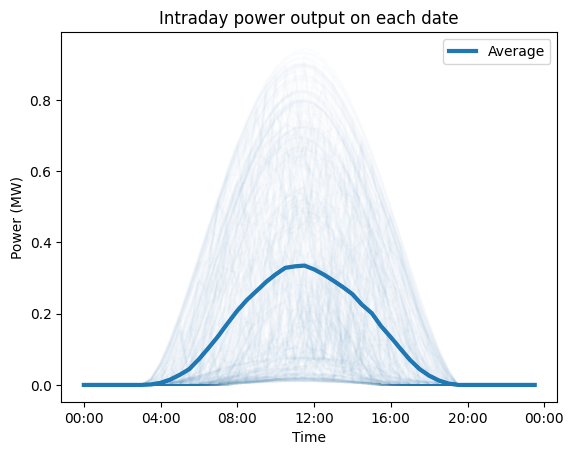

In [6]:
#Intraday power output on each date plot
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.ylabel("Power (MW)")
plt.xlabel("Time")
plt.title("Intraday power output on each date")
df2 = df.groupby("TimeOnly")[["Power(MW)"]].mean().reset_index()
plt.plot(df2["TimeOnly"], df2["Power(MW)"], linewidth=3, label="Average")
plt.legend()
for date, df2 in df.groupby('DateOnly'):
    plt.plot(df2['TimeOnly'], df2['Power(MW)'], alpha=0.01, color="C0")

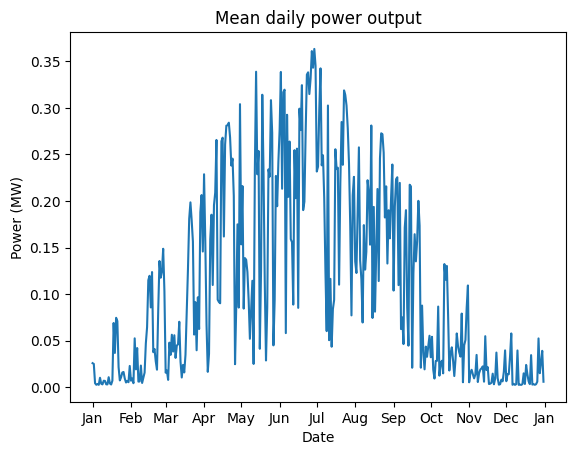

In [7]:
#Mean daily power output plot
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.ylabel("Power (MW)")
plt.xlabel("Date")
plt.title("Mean daily power output")
df2 = df.groupby("DateOnly")[["Power(MW)"]].mean().reset_index()
plt.plot(df2["DateOnly"], df2["Power(MW)"])
plt.show()

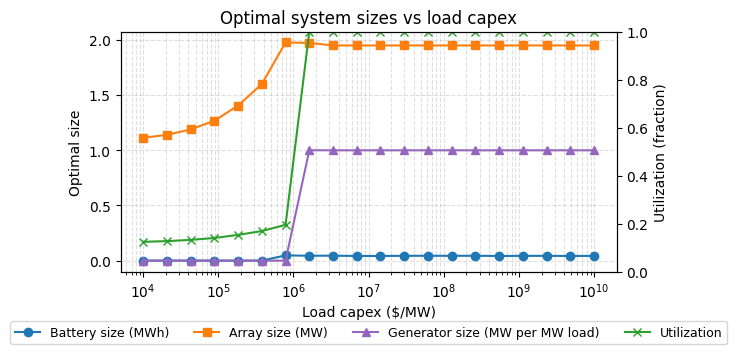

In [8]:
fig, ax1 = plt.subplots()

# Left y-axis: sizes
ax1.plot(load_costs, np.array(battery_sizes), marker='o', label='Battery size (MWh)', color='tab:blue')
ax1.plot(load_costs, np.array(array_sizes), marker='s', label='Array size (MW)', color='tab:orange')
ax1.plot(load_costs, np.array(gen_sizes), marker='^', label='Generator size (MW per MW load)', color='tab:purple')
ax1.set_xscale('log')
ax1.set_xlabel('Load capex ($/MW)')
ax1.set_ylabel('Optimal size')
ax1.set_title('Optimal system sizes vs load capex')
ax1.grid(True, which='both', ls='--', alpha=0.4)


# Right y-axis: utilization
ax2 = ax1.twinx()
ax2.plot(load_costs, np.array(uptimes), marker='x', label='Utilization', color='tab:green')
ax2.set_ylabel('Utilization (fraction)')
ax2.set_ylim(0, 1)

# Place combined legend below the plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
all_lines = lines1 + lines2
all_labels = labels1 + labels2
legend = ax1.legend(all_lines, all_labels, loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=4, fontsize=9)


# Make room at the bottom for legend + text
plt.subplots_adjust(bottom=0.38)

plt.show()


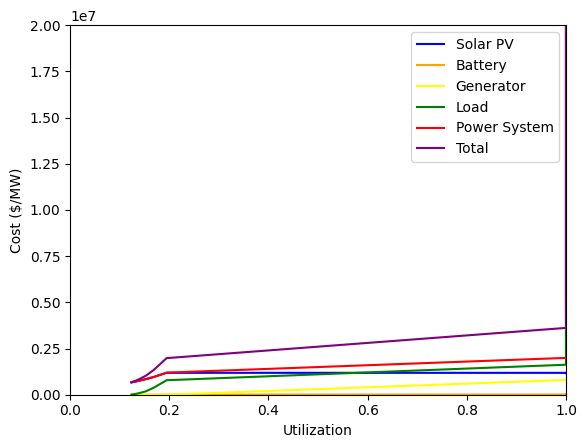

In [9]:
battery_costs = np.array(battery_sizes) * battery_cost
solar_costs = np.array(array_sizes) * solar_cost
gen_costs = np.array(gen_sizes) * gen_capex
power_system_costs = battery_costs + solar_costs + gen_costs
load_costs = np.array(load_costs)
total_costs = power_system_costs + load_costs
plt.xlim(0, 1)
plt.ylim(0, 2e7)
plt.xlabel("Utilization")
plt.ylabel("Cost ($/MW)")
plt.plot(uptimes, solar_costs, label="Solar PV", color="blue")
plt.plot(uptimes, battery_costs, label="Battery", color="orange")
plt.plot(uptimes, gen_costs, label="Generator", color="yellow")
plt.plot(uptimes, load_costs, label="Load", color="green")
plt.plot(uptimes, power_system_costs, label="Power System", color="red")
plt.plot(uptimes, total_costs, label="Total", color="purple")
plt.legend()

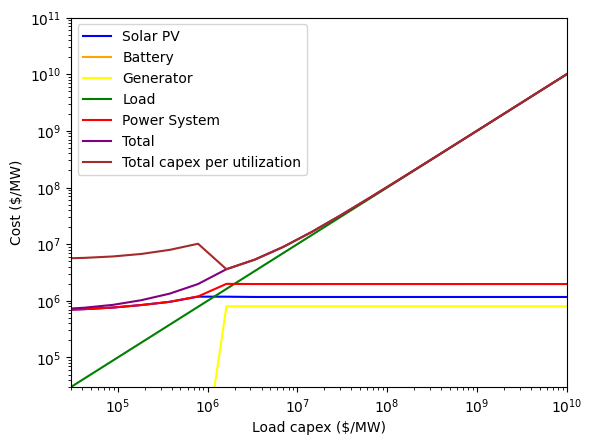

In [10]:
plt.xlim(3e4, 1e10)
plt.ylim(3e4, 1e11)
plt.xlabel("Load capex ($/MW)")
plt.ylabel("Cost ($/MW)")
plt.plot(load_costs, solar_costs, label="Solar PV", color="blue")
plt.plot(load_costs, battery_costs, label="Battery", color="orange")
plt.plot(load_costs, gen_costs, label="Generator", color="yellow")
plt.plot(load_costs, load_costs, label="Load", color="green")
plt.plot(load_costs, power_system_costs, label="Power System", color="red")
plt.plot(load_costs, total_costs, label="Total", color="purple")
plt.plot(load_costs, total_costs / uptimes, label="Total capex per utilization", color="brown")
plt.legend()
plt.yscale("log")
plt.xscale("log")

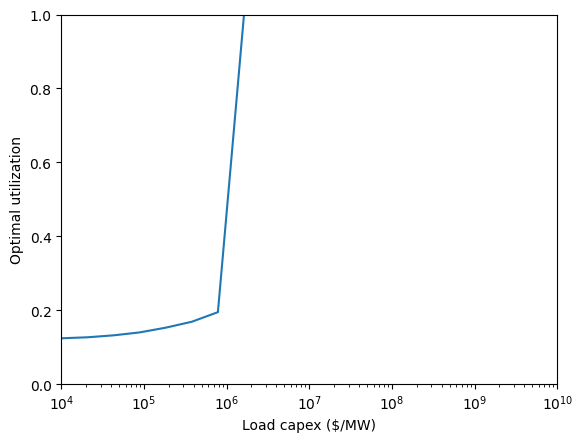

In [11]:
plt.xlim(1e4, 1e10)
plt.ylim(0, 1)
plt.xlabel("Load capex ($/MW)")
plt.ylabel("Optimal utilization")
plt.plot(load_costs, uptimes)
plt.xscale("log")

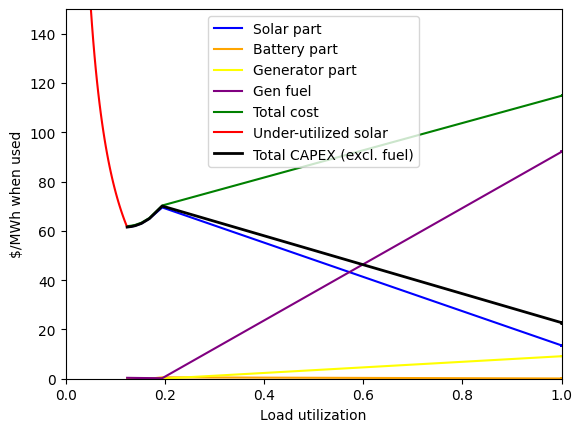

In [12]:


mwh_per_capex = 8760 / (.04 + .06) # 8760 hrs/year / (4% depreciation + 6% cost-of-capital). 87600 MWh per MW over lifetime
# This is a pretty important function for real work uses that probably cannot be encompasesd in a single calculation.

under_utilized_solar_uptimes = np.linspace(1e-5, min(uptimes))
under_utilized_solar_costs = [
min(uptimes) / x * solar_costs[0] / uptimes[0] / mwh_per_capex
for x in under_utilized_solar_uptimes
]

solar_part     = solar_costs  / uptimes / mwh_per_capex
battery_part   = battery_costs / uptimes / mwh_per_capex
gen_capex_part = gen_costs    / uptimes / mwh_per_capex
fuel_part      = fuel_costs   # already $/MWh


total_LCOE = solar_part + battery_part + gen_capex_part + fuel_part
total_capex_part = solar_part + battery_part + gen_capex_part


plt.xlim(0, 1)
plt.ylim(0, 150)
plt.xlabel("Load utilization")
plt.ylabel("$/MWh when used")
plt.plot(uptimes, solar_part, label="Solar part", color="blue")
plt.plot(uptimes, battery_part, label="Battery part", color="orange")
plt.plot(uptimes, gen_capex_part, label="Generator part", color="yellow")
plt.plot(uptimes, fuel_part, label="Gen fuel", color="purple")
plt.plot(uptimes, total_LCOE, label="Total cost", color="green")
plt.plot(under_utilized_solar_uptimes, under_utilized_solar_costs, label="Under-utilized solar", color="red")
plt.plot(uptimes, total_capex_part, label="Total CAPEX (excl. fuel)", color="black", linewidth=2)
plt.legend()

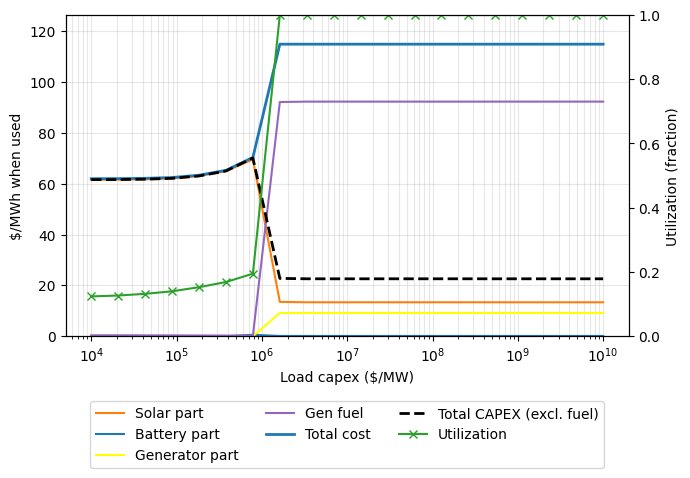

In [13]:
fig, ax1 = plt.subplots(figsize=(7, 5))

ax1.set_xscale("log")
ax1.set_xlabel("Load capex ($/MW)")
ax1.set_ylabel("$/MWh when used")

# determine y-limits from the plotted series so the axis "scales with the values"
left_series = np.concatenate([
    np.asarray(solar_part),
    np.asarray(battery_part),
    np.asarray(gen_capex_part),
    np.asarray(fuel_part),
    np.asarray(total_LCOE),
    np.asarray(total_capex_part),
])
y_min = np.nanmin(left_series)
y_max = np.nanmax(left_series)
margin = 0.1 * (y_max - y_min) if (y_max > y_min) else 1.0
y_lower = max(0.0, y_min - margin)
y_upper = y_max + margin
ax1.set_ylim(y_lower, y_upper)

# plot cost components on left y-axis
ax1.plot(load_costs, solar_part,     label="Solar part", color="tab:orange")
ax1.plot(load_costs, battery_part,   label="Battery part", color="tab:blue")
ax1.plot(load_costs, gen_capex_part, label="Generator part", color="yellow")
ax1.plot(load_costs, fuel_part,      label="Gen fuel", color="tab:purple")
ax1.plot(load_costs, total_LCOE,     label="Total cost", linewidth=2)
ax1.plot(load_costs, total_capex_part,
         label="Total CAPEX (excl. fuel)", linestyle="--", linewidth=2, color="black")

# secondary y-axis: utilization
ax2 = ax1.twinx()
ax2.plot(load_costs, uptimes, label="Utilization", color="tab:green", marker='x')
ax2.set_ylabel("Utilization (fraction)")
ax2.set_ylim(0, 1)

# combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
ax1.grid(True, which="both", alpha=0.3)
plt.tight_layout()



In [14]:
'''
fig, ax1 = plt.subplots(figsize=(7, 5))

ax1.set_xscale("log")
ax1.set_xlim(1e4, 1e8)
ax1.set_xlabel("Load capex ($/MW)")
ax1.set_ylabel("$/MWh when used")

# prepare series for log plotting: replace non-positive values with NaN so matplotlib doesn't error
def _pos_or_nan(x):
    a = np.asarray(x, dtype=float).copy()
    a[a <= 0] = np.nan
    return a

solar_plot = _pos_or_nan(solar_part)
battery_plot = _pos_or_nan(battery_part)
gen_capex_plot = _pos_or_nan(gen_capex_part)
fuel_plot = _pos_or_nan(fuel_part)
total_plot = _pos_or_nan(total_LCOE)
capex_plot = _pos_or_nan(total_capex_part)

# set y-axis to log scale (cannot include zero)
ax1.set_yscale("log")
ax1.set_ylim(0, 1e3)

# plot cost components on left y-axis
#ax1.plot(load_costs, solar_plot,     label="Solar part", color="tab:orange")
#ax1.plot(load_costs, battery_plot,   label="Battery part", color="tab:blue")
ax1.plot(load_costs, gen_capex_plot, label="Generator part", color="yellow")
ax1.plot(load_costs, fuel_plot,      label="Gen fuel", color="tab:purple")
ax1.plot(load_costs, total_plot,     label="Total cost", linewidth=2)
ax1.plot(load_costs, capex_plot,
         label="Total CAPEX (excl. fuel)", linestyle="--", linewidth=2, color="black")

# secondary y-axis: utilization (linear)
ax2 = ax1.twinx()
#ax2.plot(load_costs, uptimes, label="Utilization", color="tab:green", marker='x')
ax2.set_ylabel("Utilization (fraction)")
ax2.set_ylim(0, 1)

# combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
ax1.grid(True, which="both", alpha=0.3)
plt.tight_layout()
'''

'\nfig, ax1 = plt.subplots(figsize=(7, 5))\n\nax1.set_xscale("log")\nax1.set_xlim(1e4, 1e8)\nax1.set_xlabel("Load capex ($/MW)")\nax1.set_ylabel("$/MWh when used")\n\n# prepare series for log plotting: replace non-positive values with NaN so matplotlib doesn\'t error\ndef _pos_or_nan(x):\n    a = np.asarray(x, dtype=float).copy()\n    a[a <= 0] = np.nan\n    return a\n\nsolar_plot = _pos_or_nan(solar_part)\nbattery_plot = _pos_or_nan(battery_part)\ngen_capex_plot = _pos_or_nan(gen_capex_part)\nfuel_plot = _pos_or_nan(fuel_part)\ntotal_plot = _pos_or_nan(total_LCOE)\ncapex_plot = _pos_or_nan(total_capex_part)\n\n# set y-axis to log scale (cannot include zero)\nax1.set_yscale("log")\nax1.set_ylim(0, 1e3)\n\n# plot cost components on left y-axis\n#ax1.plot(load_costs, solar_plot,     label="Solar part", color="tab:orange")\n#ax1.plot(load_costs, battery_plot,   label="Battery part", color="tab:blue")\nax1.plot(load_costs, gen_capex_plot, label="Generator part", color="yellow")\nax1.plot(l